This Python script is designed for training, validating, and testing a YOLOv5 model to detect rust in images. It utilizes a COCO-style dataset and incorporates essential components for dataset preprocessing, model setup, and evaluation. The script also includes visualization capabilities to render bounding box predictions on test images.

The preprocessing stage involves converting bounding box formats from [x_min, y_min, x_max, y_max] to YOLO format [x_center, y_center, width, height] for compatibility with YOLOv5. Functions are provided to parse YOLO label files and convert bounding boxes to the required format.

The model is initialized using a pre-trained YOLOv5s model. The get_model function loads the YOLOv5 model. Optimizer parameters and learning rate scheduling are handled internally by the YOLOv5 framework.

The train_model function is the core of the training process, iterating over multiple epochs while logging training and validation losses. Validation is performed using the validate_model function, which evaluates the model on the validation dataset. The script also saves the trained model weights to a file for future use. A plot of training and validation loss is generated at the end to visualize the model's performance.

Testing involves the test_model function, which predicts bounding boxes on the test dataset. The function calculates precision, recall, F1-score, and accuracy to evaluate the model's performance. The script also includes a function to plot loss curves from the training process.

To use the script, prepare a COCO-style dataset with separate directories for training, validation, and testing images, along with corresponding annotation files. Update the dataset_dir variable to point to the dataset location. Running the script trains the model and evaluates its performance on the test set, generating predictions and saving results.

The output includes a trained model saved as best.pt, evaluation metrics, and a plot of training and validation losses. For enhancements, consider adding test accuracy tracking, early stopping, and data augmentation for improved robustness and generalization.

In [ ]:
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm import tqdm
from ultralytics import YOLO  # YOLOv5 framework
import matplotlib.pyplot as plt

# Ensure plots are displayed in the notebook
%matplotlib inline

# === Data Preprocessing ===
def convert_to_yolo_format(bbox_list, image_width, image_height):
    """Convert bounding boxes from [x_min, y_min, x_max, y_max] to YOLO format [x_center, y_center, width, height]."""
    yolo_bboxes = []
    for x_min, y_min, x_max, y_max in bbox_list:
        x_center = (x_min + x_max) / 2 / image_width
        y_center = (y_min + y_max) / 2 / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height
        yolo_bboxes.append([x_center, y_center, width, height])
    return yolo_bboxes

def parse_yolo_labels(label_file):
    """Parse YOLO label files and return ground-truth labels and bounding boxes."""
    labels, bboxes = [], []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue  # Skip invalid lines
            labels.append(int(parts[0]))  # Class ID
            bboxes.append([float(x) for x in parts[1:]])  # Normalized bbox [x_center, y_center, width, height]
    return labels, bboxes

# === Run Training and Testing ===
def train_model(model, data_yaml, num_epochs=50, batch_size=8):
    """Train YOLOv5 on the specified dataset."""
    print("\n=== Starting Training ===")
    model.train(data=data_yaml, epochs=num_epochs, batch=batch_size)

# === Validation ===
def validate_model(model, data_yaml):
    """Validate YOLOv5 on the validation dataset."""
    print("\n=== Validating Model ===")
    results = model.val(data=data_yaml)
    print(f"Validation Results: {results}")
    return results

# === Paths ===
current_directory = os.getcwd()
dataset_dir = os.path.join(current_directory, "dataset")
data_yaml = os.path.join(dataset_dir, "data.yaml")

# Debug: Print paths
print(f"Current Directory: {current_directory}")
print(f"Dataset Directory: {dataset_dir}")
print(f"Data YAML Path: {data_yaml}")

# Verify if paths exist
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory does not exist at {dataset_dir}")
if not os.path.exists(data_yaml):
    print(f"Error: data.yaml file does not exist at {data_yaml}")

# Verify contents of dataset directory
print("Contents of dataset directory:")
print(os.listdir(dataset_dir))

# === Model Setup ===
def get_model():
    """Load the YOLO model."""
    model = YOLO('yolov5s.pt')  # Pretrained YOLOv5s model
    return model

model = get_model()
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print("Model loaded successfully and is running on", device)





Current Directory: /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO
Dataset Directory: /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset
Data YAML Path: /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/data.yaml
Contents of dataset directory:
['valid', 'label_convert.log', '.DS_Store', 'dataset_trimmer.py', 'data.yaml', 'label_convert.py', 'train']
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Model loaded successfully and is running on mps


In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score

def load_trained_model(weights_path):
    """Load a trained YOLO model from the specified weights path."""
    model = YOLO(weights_path)
    model.to(device)
    return model

def plot_loss_curve(log_dir):
    """Plot training and validation loss curves."""
    loss_file = os.path.join(log_dir, "results.csv")
    if os.path.exists(loss_file):
        import pandas as pd
        data = pd.read_csv(loss_file)
        plt.plot(data["epoch"], data["train/box_loss"], label="Box Loss")
        plt.plot(data["epoch"], data["train/dfl_loss"], label="DFL Loss")
        plt.plot(data["epoch"], data["train/cls_loss"], label="Classification Loss")

        plt.plot(data["epoch"], data["val/box_loss"], label="Validation Box Loss", linestyle="--")
        plt.plot(data["epoch"], data["val/dfl_loss"], label="Validation DFL Loss", linestyle="--")
        plt.plot(data["epoch"], data["val/cls_loss"], label="Validation Classification Loss", linestyle="--")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Curves")
        plt.grid()
        plt.show()

    else:
        print("No loss file found for plotting.")

def calculate_metrics_per_image(y_true_grouped, y_pred_grouped):
    """Calculate precision, recall, F1-score, and accuracy for each image."""
    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_accuracies = []

    for y_true, y_pred in zip(y_true_grouped, y_pred_grouped):
        if not y_true and not y_pred:
            # Skip metrics calculation for empty ground truth and predictions
            continue
        
        # Handle empty predictions or ground truth
        if not y_pred:
            y_pred = [None] * len(y_true)  # Add dummy values
        elif not y_true:
            y_true = [None] * len(y_pred)  # Add dummy values
        
        # Calculate metrics
        try:
            precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
        except ValueError as e:
            print(f"Error calculating metrics for y_true={y_true}, y_pred={y_pred}: {e}")
            continue

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_accuracies.append(accuracy)

    return {
        "precision": sum(all_precisions) / len(all_precisions) if all_precisions else 0,
        "recall": sum(all_recalls) / len(all_recalls) if all_recalls else 0,
        "f1": sum(all_f1s) / len(all_f1s) if all_f1s else 0,
        "accuracy": sum(all_accuracies) / len(all_accuracies) if all_accuracies else 0,
    }


def test_model(model, image_dir, label_dir):
    """Run YOLOv5 inference on test images and calculate metrics."""
    print("\n=== Testing Model ===")
    results = model.predict(source=image_dir, save=False)

    y_true_grouped = []
    y_pred_grouped = []

    # Iterate over predictions and compare with ground-truth labels
    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path).rsplit('.', 1)[0]
        label_file = os.path.join(label_dir, f"{image_name}.txt")

        true_labels = []
        if os.path.exists(label_file):
            true_labels, _ = parse_yolo_labels(label_file)  # Parse ground-truth labels

        # Get YOLO predictions
        pred_labels = []
        if result.boxes is not None:  # Ensure there are predictions
            pred_labels = result.boxes.cls.cpu().numpy().astype(int).tolist()

        # Add to grouped lists
        y_true_grouped.append(true_labels)
        y_pred_grouped.append(pred_labels)

        # Debug: Print predictions and ground truth for this image
        print(f"Image: {image_name}")
        print(f"Ground Truth: {true_labels}")
        print(f"Predictions: {pred_labels}")

    # Calculate metrics across all images
    metrics = calculate_metrics_per_image(y_true_grouped, y_pred_grouped)

    return metrics


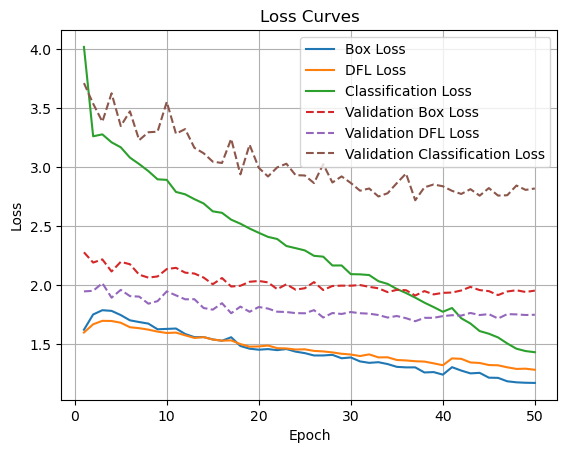

In [91]:
# train_model(model, data_yaml=data_yaml, num_epochs=10, batch_size=8)
weights_path = 'trained_weights/ssh2/weights/best.pt'  # Update 'expX' to the correct experiment number
trained_model = load_trained_model(weights_path)
plot_loss_curve('/Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/trained_weights/ssh2')  # Update 'expX' to the correct experiment number

In [92]:
validate_model(trained_model, data_yaml=data_yaml)


=== Validating Model ===
YOLOv5s summary (fused): 193 layers, 9,115,406 parameters, 0 gradients, 23.8 GFLOPs


val: Scanning /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/valid/labels.cache... 197 images, 98 backgrounds, 0 corrupt: 100%|██████████| 295/295 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:08<02:41,  8.95s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:13<01:52,  6.62s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:24<02:15,  8.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:31<01:59,  7.96s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:42<02:05,  8.93s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:51<01:55,  8.89s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:57<01:37,  8.10s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [01:07<01:33,  8.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [01:12<01:15,  7.51s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:17<00:59,  6.66s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:26<00:59,  7.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:34<00:53,  7.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:41<00:44,  7.35s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:52<00:42,  8.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [01:59<00:31,  7.93s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [02:05<00:22,  7.44s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [02:13<00:15,  7.65s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [02:19<00:07,  7.31s/it]

WARNING ⚠️ NMS time limit 2.350s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:25<00:00,  7.68s/it]


                   all        295        872      0.578      0.185      0.206      0.129
                  Rust          1          2          1      0.935      0.995      0.614
         corroded-part         10         12       0.14      0.167      0.137      0.112
        mild-corrosion         82        364          1          0     0.0398     0.0142
    moderate-corrosion         76        203          0          0     0.0239     0.0103
                  rust          4          9          1          0          0          0
      severe-corrosion        125        282      0.327    0.00709     0.0371     0.0238
Speed: 34.6ms preprocess, 54.5ms inference, 0.0ms loss, 228.5ms postprocess per image
Results saved to runs/detect/val2
Validation Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 3, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x9e4003800>
curv

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 3, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x9e4003800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [93]:
test_model(trained_model, image_dir=os.path.join(dataset_dir, "test/images"), label_dir=os.path.join(dataset_dir, "test/labels"))


=== Testing Model ===

image 1/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/0_original_corrosion_detected-1-_png_jpg.rf.a1114d6b02ccdeb68c731b83aafd95e5.jpg: 640x640 2 moderate-corrosions, 32.8ms
image 2/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/0_original_corrosion_detected-1-_png_jpg.rf.d5ff0efdb26bd1028915fb30199e6bec.jpg: 640x640 (no detections), 18.2ms
image 3/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/101806006_13067922921_jpg.rf.f53fd18aa237b7dfa8e32ebaefd9e0f9.jpg: 640x640 1 corroded-part, 1 severe-corrosion, 18.5ms
image 4/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/1_original_corrosion_detected-1-_png_jpg.rf.6ac2ff21d119dd11b65bd228ab7b6303.jpg: 640x640 1 moderate-corrosion, 20.7ms
image 5/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/1_original_corrosion_detected-1-_p

{'precision': 0.8036702127659575,
 'recall': 0.8117021276595744,
 'f1': 0.8058257345491389,
 'accuracy': 0.8117021276595744}


image 1/4 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/test_images/test.png: 640x480 (no detections), 895.1ms
image 2/4 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/test_images/test1.png: 480x640 (no detections), 64.8ms
image 3/4 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/test_images/test2.png: 480x640 1 rust, 28.3ms
image 4/4 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/test_images/test3.png: 448x640 1 rust, 1 severe-corrosion, 81.8ms
Speed: 8.9ms preprocess, 267.5ms inference, 14.9ms postprocess per image at shape (1, 3, 448, 640)


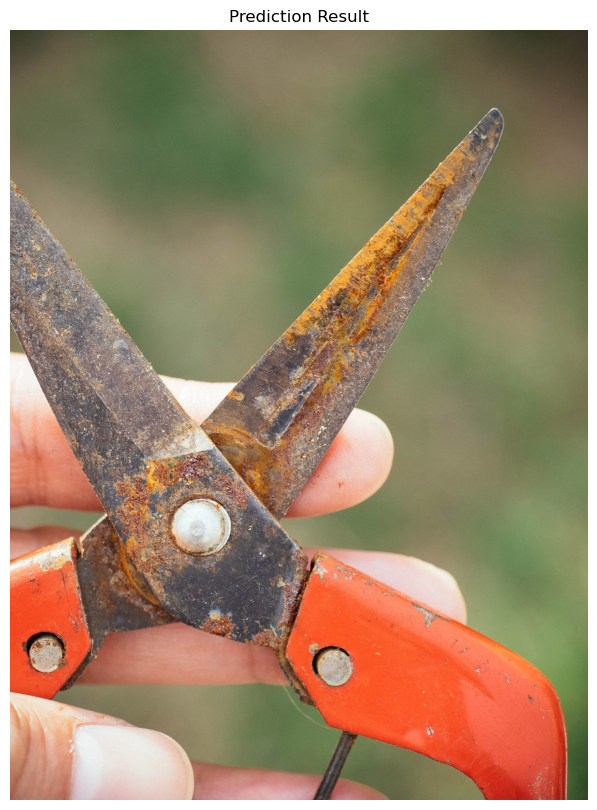

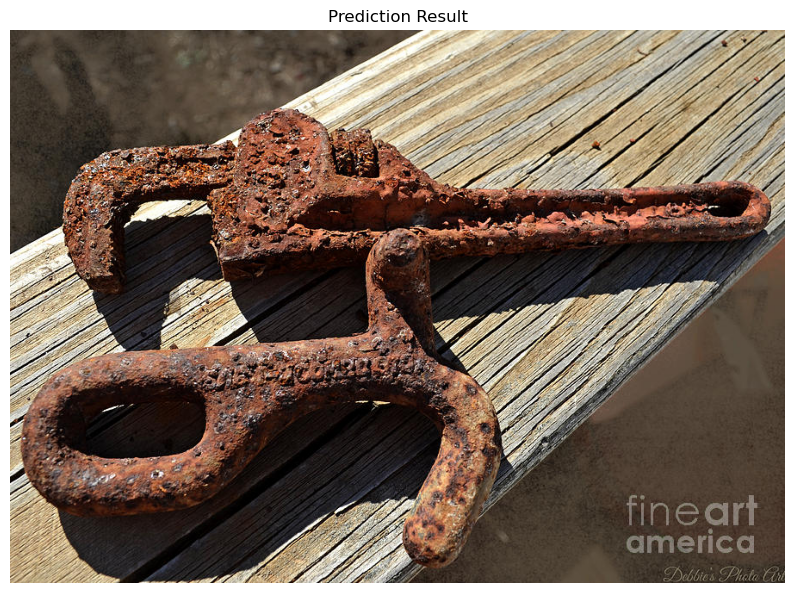

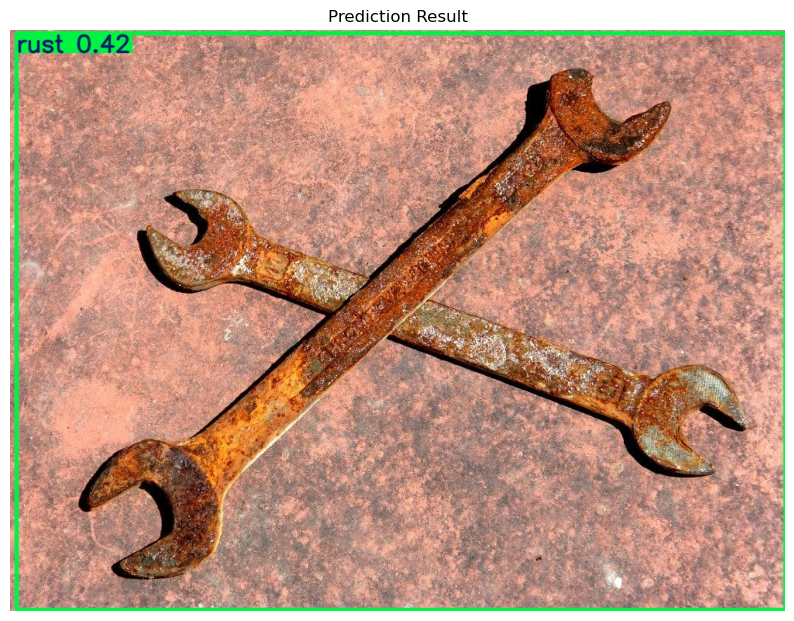

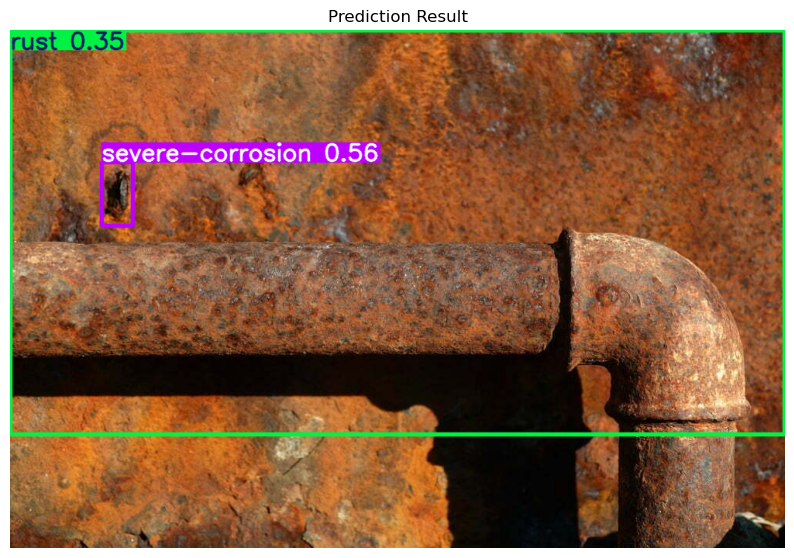

In [116]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt

# Run an image through the model
results = trained_model.predict(source='test_images', save=False, show=False)

# Loop through the results and display them
for result in results:
    # Get the image with predictions rendered
    rendered_image = result.plot()

    # Convert the BGR (default OpenCV format) to RGB if needed
    rendered_image_rgb = cv2.cvtColor(rendered_image, cv2.COLOR_BGR2RGB)

    # Display the corrected image
    plt.figure(figsize=(10, 10))
    plt.imshow(rendered_image_rgb)
    plt.axis('off')  # Turn off axis
    plt.title("Prediction Result")
    plt.show()


